<a href="https://colab.research.google.com/github/ping-Mel/ERV-V2-Assignments/blob/main/session8/s8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Models:
    """
    In this class, we organize our neural network architectures as nested/inner classes.
    This approach groups related functionalities and creates an organized and encapsulated
    code structure. Each neural network architecture is defined as an inner class within
    this Models class. This allows for easy instantiation and clear hierarchy of neural
    network models, each with its distinct architecture and characteristics.
    """
    @staticmethod
    def evaluate_model(model_class, input_size=(3, 32, 32)):
        """
        Static method to evaluate the model architecture.
        This method will print a summary of the model showing the layers and parameters.

        Parameters:
        model_class (class): The inner class representing the neural network architecture to evaluate.
        input_size (tuple): The size of the input to the model. Default is (1, 28, 28) for MNIST dataset.
        """
        # Check for CUDA availability and set the device accordingly
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")

        # Initialize the model from the inner class and move to the appropriate device
        model = model_class().to(device)

        # Print the summary of the model
        summary(model, input_size=input_size)



    class NetA(nn.Module):
        """
        Inner class representing an initial neural network architecture.
        """
        def __init__(self):
            super(Models.NetA, self).__init__()
            # Convolutional layers
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 1     32     1   1    3      30     1    0  3
            self.convblock1 = nn.Sequential(
              nn.Conv2d(3, 32, 3),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 3     30    1    1    5      30     1    1  3
            self.convblock2 = nn.Sequential(
              nn.Conv2d(32, 16, 3,padding=1),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5      30    1   1    5      30     1    0  1
            self.convblock3 = nn.Sequential(
              nn.Conv2d(16, 16, kernel_size=1),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5     30    1    2    6      15     2    0  2
            self.pool1 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            #  6    15     2   1    10     15     2   1  3
            self.convblock4 = nn.Sequential(
              nn.Conv2d(16, 16, 3,padding=1),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 10    15     2   1    14     15     2    1  3
            self.convblock5 = nn.Sequential(
              nn.Conv2d(16, 32, 3,padding=1),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 14    15     2   1    18     15     2    1  3
            self.convblock6 = nn.Sequential(
              nn.Conv2d(32, 32, 3,padding=1),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 18    15     2   1    18     15     2    0  1
            self.convblock7 = nn.Sequential(
              nn.Conv2d(32, 32, kernel_size=1),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 18    15     2   2    20     7      4  0  2
            self.pool2 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 20    7     4    1    28     5      4    0  3
            self.convblock8 = nn.Sequential(
              nn.Conv2d(32, 16, 3),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 28    5     4    1    36     3     4     0  3
            self.convblock9 = nn.Sequential(
              nn.Conv2d(16, 32, 3),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 36    3     4    1    44     1     4     0  3
            self.convblock10 = nn.Sequential(
              nn.Conv2d(32, 32, 3),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))  # Global pooling to reduce parameters

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 44    2     4    1    44     1     4     0  1
            self.convblock11 = nn.Sequential(
              nn.Conv2d(32, 10, kernel_size=1)
            )

        def forward(self, x):
            x = self.convblock1(x)
            x = self.convblock2(x)
            x = self.convblock3(x)  # 1x1 conv
            x = self.pool1(x)

            x = self.convblock4(x)
            x = self.convblock5(x)
            x = self.convblock6(x)
            x = self.convblock7(x)  # 1x1 conv
            x = self.pool2(x)

            x = self.convblock8(x)
            x = self.convblock9(x)
            x = self.convblock10(x)

            x = self.global_avg_pool(x)
            x = self.convblock11(x)  # Final 1x1 conv

            # Flatten for the final output
            x = x.view(x.size(0), -1)
            return F.log_softmax(x, dim=-1)



    class NetB(nn.Module):
        """
        Inner class representing an initial neural network architecture.
        """
        def __init__(self):
            super(Models.NetB, self).__init__()
            # Convolutional layers
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 1     32     1   1    3      30     1    0  3
            self.convblock1 = nn.Sequential(
              nn.Conv2d(3, 32, 3),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 3     30    1    1    5      30     1    1  3
            self.convblock2 = nn.Sequential(
              nn.Conv2d(32, 16, 3,padding=1),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5      30    1   1    5      30     1    0  1
            self.convblock3 = nn.Sequential(
              nn.Conv2d(16, 16, kernel_size=1),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5     30    1    2    6      15     2    0  2
            self.pool1 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            #  6    15     2   1    10     15     2   1  3
            self.convblock4 = nn.Sequential(
              nn.Conv2d(16, 16, 3,padding=1),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.LayerNorm(normalized_shape=[16, 15, 15])
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 10    15     2   1    14     15     2    1  3
            self.convblock5 = nn.Sequential(
              nn.Conv2d(16, 16, 3,padding=1),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.LayerNorm(normalized_shape=[16, 15, 15])
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 14    15     2   1    18     15     2    1  3
            self.convblock6 = nn.Sequential(
              nn.Conv2d(16, 32, 3,padding=1),
              nn.ReLU(),
              nn.Dropout(0.1)

            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 18    15     2   1    18     15     2    0  1
            self.convblock7 = nn.Sequential(
              nn.Conv2d(32, 32, kernel_size=1),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 18    15     2   2    20     7      4  0  2
            self.pool2 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 20    7     4    1    28     5      4    0  3
            self.convblock8 = nn.Sequential(
              nn.Conv2d(32, 16, 3),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.LayerNorm(normalized_shape=[16, 5, 5])
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 28    5     4    1    36     3     4     0  3
            self.convblock9 = nn.Sequential(
              nn.Conv2d(16, 32, 3),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.LayerNorm(normalized_shape=[32, 3, 3])
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 36    3     4    1    44     1     4     0  3
            self.convblock10 = nn.Sequential(
              nn.Conv2d(32, 32, 3),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.LayerNorm(normalized_shape=[32, 1, 1])
            )
            self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))  # Global pooling to reduce parameters

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 44    2     4    1    44     1     4     0  1
            self.convblock11 = nn.Sequential(
              nn.Conv2d(32, 10, kernel_size=1)
            )

        def forward(self, x):
            x = self.convblock1(x)
            x = self.convblock2(x)
            x = self.convblock3(x)  # 1x1 conv
            x = self.pool1(x)

            x = self.convblock4(x)
            x = self.convblock5(x)
            x = self.convblock6(x)
            x = self.convblock7(x)  # 1x1 conv
            x = self.pool2(x)

            x = self.convblock8(x)
            x = self.convblock9(x)
            x = self.convblock10(x)

            x = self.global_avg_pool(x)
            x = self.convblock11(x)  # Final 1x1 conv

            # Flatten for the final output
            x = x.view(x.size(0), -1)
            return F.log_softmax(x, dim=-1)

# Target 1: Group Normalisation Network

## Initial Setup
- Construct the **basic skeleton** of the neural network model. This includes defining the layers and forward pass logic in Class Models (model.py) NetA inner class.
-

## Aim
1.   **70%** (this must be consistently shown in your last few epochs, and not a one-time achievement)
2.   Less than or equal to **20** Epochs
3.   Less than **50k** Parameters

In [35]:
!pip install torchsummary

from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [36]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.49139968, 0.48215827, 0.44653124)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.49139968, 0.48215827, 0.44653124))
                                       ])

In [37]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [39]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


In [49]:
Models.evaluate_model(Models.NetA)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 16, 30, 30]           4,624
       BatchNorm2d-6           [-1, 16, 30, 30]              32
              ReLU-7           [-1, 16, 30, 30]               0
           Dropout-8           [-1, 16, 30, 30]               0
            Conv2d-9           [-1, 16, 30, 30]             272
      BatchNorm2d-10           [-1, 16, 30, 30]              32
             ReLU-11           [-1, 16, 30, 30]               0
          Dropout-12           [-1, 16, 30, 30]               0
        MaxPool2d-13           [-1, 16, 15, 15]               0
           Conv2d-14           [-1, 16,

In [50]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Models.NetA().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.5938031673431396 Batch_id=195 Accuracy=34.37%: 100%|██████████| 196/196 [00:14<00:00, 13.09it/s]



Test set: Average loss: 1.7507, Accuracy: 3743/10000 (37.43%)

EPOCH: 1


Loss=1.2621979713439941 Batch_id=195 Accuracy=49.35%: 100%|██████████| 196/196 [00:15<00:00, 13.00it/s]



Test set: Average loss: 1.7048, Accuracy: 3975/10000 (39.75%)

EPOCH: 2


Loss=1.1282514333724976 Batch_id=195 Accuracy=55.76%: 100%|██████████| 196/196 [00:14<00:00, 13.36it/s]



Test set: Average loss: 1.3487, Accuracy: 5060/10000 (50.60%)

EPOCH: 3


Loss=1.16852867603302 Batch_id=195 Accuracy=59.89%: 100%|██████████| 196/196 [00:14<00:00, 13.17it/s]



Test set: Average loss: 1.3274, Accuracy: 5385/10000 (53.85%)

EPOCH: 4


Loss=1.0404374599456787 Batch_id=195 Accuracy=62.52%: 100%|██████████| 196/196 [00:15<00:00, 12.69it/s]



Test set: Average loss: 1.2191, Accuracy: 5809/10000 (58.09%)

EPOCH: 5


Loss=0.9956246614456177 Batch_id=195 Accuracy=64.63%: 100%|██████████| 196/196 [00:14<00:00, 13.33it/s]



Test set: Average loss: 1.1505, Accuracy: 6076/10000 (60.76%)

EPOCH: 6


Loss=1.0459511280059814 Batch_id=195 Accuracy=66.09%: 100%|██████████| 196/196 [00:14<00:00, 13.34it/s]



Test set: Average loss: 1.1821, Accuracy: 5955/10000 (59.55%)

EPOCH: 7


Loss=0.8914422988891602 Batch_id=195 Accuracy=67.17%: 100%|██████████| 196/196 [00:15<00:00, 12.85it/s]



Test set: Average loss: 1.1635, Accuracy: 6016/10000 (60.16%)

EPOCH: 8


Loss=0.9841941595077515 Batch_id=195 Accuracy=68.65%: 100%|██████████| 196/196 [00:14<00:00, 13.22it/s]



Test set: Average loss: 1.1390, Accuracy: 6031/10000 (60.31%)

EPOCH: 9


Loss=1.1837407350540161 Batch_id=195 Accuracy=69.51%: 100%|██████████| 196/196 [00:15<00:00, 12.84it/s]



Test set: Average loss: 1.0852, Accuracy: 6298/10000 (62.98%)

EPOCH: 10


Loss=1.0864793062210083 Batch_id=195 Accuracy=70.43%: 100%|██████████| 196/196 [00:14<00:00, 13.08it/s]



Test set: Average loss: 0.9500, Accuracy: 6727/10000 (67.27%)

EPOCH: 11


Loss=0.9150959849357605 Batch_id=195 Accuracy=71.46%: 100%|██████████| 196/196 [00:14<00:00, 13.18it/s]



Test set: Average loss: 0.8090, Accuracy: 7183/10000 (71.83%)

EPOCH: 12


Loss=0.6754927039146423 Batch_id=195 Accuracy=72.01%: 100%|██████████| 196/196 [00:15<00:00, 12.94it/s]



Test set: Average loss: 0.8888, Accuracy: 6942/10000 (69.42%)

EPOCH: 13


Loss=0.7484990358352661 Batch_id=195 Accuracy=72.57%: 100%|██████████| 196/196 [00:15<00:00, 13.05it/s]



Test set: Average loss: 0.9660, Accuracy: 6682/10000 (66.82%)

EPOCH: 14


Loss=1.0776233673095703 Batch_id=195 Accuracy=72.97%: 100%|██████████| 196/196 [00:14<00:00, 13.32it/s]



Test set: Average loss: 0.8721, Accuracy: 7011/10000 (70.11%)

EPOCH: 15


Loss=1.0343141555786133 Batch_id=195 Accuracy=73.35%: 100%|██████████| 196/196 [00:14<00:00, 13.40it/s]



Test set: Average loss: 0.9324, Accuracy: 6808/10000 (68.08%)

EPOCH: 16


Loss=0.6755862832069397 Batch_id=195 Accuracy=74.07%: 100%|██████████| 196/196 [00:14<00:00, 13.36it/s]



Test set: Average loss: 0.8372, Accuracy: 7138/10000 (71.38%)

EPOCH: 17


Loss=0.7121050357818604 Batch_id=195 Accuracy=74.50%: 100%|██████████| 196/196 [00:15<00:00, 12.62it/s]



Test set: Average loss: 0.7982, Accuracy: 7253/10000 (72.53%)

EPOCH: 18


Loss=0.7760124802589417 Batch_id=195 Accuracy=74.73%: 100%|██████████| 196/196 [00:14<00:00, 13.36it/s]



Test set: Average loss: 0.8105, Accuracy: 7218/10000 (72.18%)

EPOCH: 19


Loss=0.7301781177520752 Batch_id=195 Accuracy=75.01%: 100%|██████████| 196/196 [00:14<00:00, 13.38it/s]



Test set: Average loss: 0.7905, Accuracy: 7308/10000 (73.08%)



Text(0.5, 1.0, 'Test Accuracy')

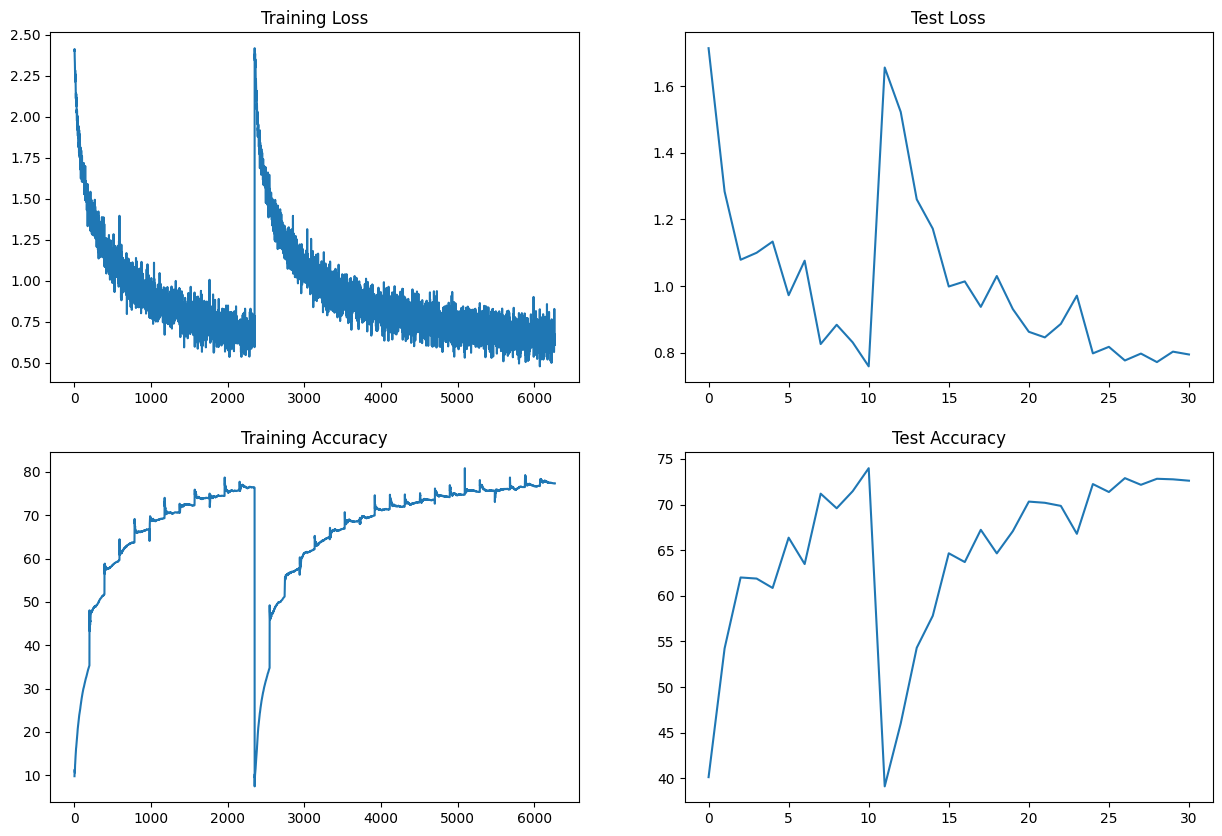

In [47]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [76]:
Models.evaluate_model(Models.NetB)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
              ReLU-2           [-1, 32, 30, 30]               0
           Dropout-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 16, 30, 30]           4,624
              ReLU-5           [-1, 16, 30, 30]               0
           Dropout-6           [-1, 16, 30, 30]               0
            Conv2d-7           [-1, 16, 30, 30]             272
              ReLU-8           [-1, 16, 30, 30]               0
           Dropout-9           [-1, 16, 30, 30]               0
        MaxPool2d-10           [-1, 16, 15, 15]               0
           Conv2d-11           [-1, 16, 15, 15]           2,320
             ReLU-12           [-1, 16, 15, 15]               0
          Dropout-13           [-1, 16, 15, 15]               0
        LayerNorm-14           [-1, 16,

In [77]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Models.NetB().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.9256550073623657 Batch_id=195 Accuracy=13.56%: 100%|██████████| 196/196 [00:14<00:00, 13.55it/s]



Test set: Average loss: 2.1324, Accuracy: 2219/10000 (22.19%)

EPOCH: 1


Loss=1.681298851966858 Batch_id=195 Accuracy=32.04%: 100%|██████████| 196/196 [00:15<00:00, 12.93it/s]



Test set: Average loss: 1.6404, Accuracy: 3903/10000 (39.03%)

EPOCH: 2


Loss=1.3695018291473389 Batch_id=195 Accuracy=39.55%: 100%|██████████| 196/196 [00:15<00:00, 13.00it/s]



Test set: Average loss: 1.5659, Accuracy: 4236/10000 (42.36%)

EPOCH: 3


Loss=1.3918581008911133 Batch_id=195 Accuracy=43.89%: 100%|██████████| 196/196 [00:14<00:00, 13.44it/s]



Test set: Average loss: 1.4444, Accuracy: 4731/10000 (47.31%)

EPOCH: 4


Loss=1.4580639600753784 Batch_id=195 Accuracy=47.50%: 100%|██████████| 196/196 [00:14<00:00, 13.42it/s]



Test set: Average loss: 1.3074, Accuracy: 5262/10000 (52.62%)

EPOCH: 5


Loss=1.1593985557556152 Batch_id=195 Accuracy=50.24%: 100%|██████████| 196/196 [00:13<00:00, 14.15it/s]



Test set: Average loss: 1.3579, Accuracy: 5206/10000 (52.06%)

EPOCH: 6


Loss=1.3439323902130127 Batch_id=195 Accuracy=52.67%: 100%|██████████| 196/196 [00:14<00:00, 13.66it/s]



Test set: Average loss: 1.2793, Accuracy: 5493/10000 (54.93%)

EPOCH: 7


Loss=1.3190912008285522 Batch_id=195 Accuracy=53.74%: 100%|██████████| 196/196 [00:14<00:00, 13.39it/s]



Test set: Average loss: 1.1801, Accuracy: 5783/10000 (57.83%)

EPOCH: 8


Loss=1.1927646398544312 Batch_id=195 Accuracy=56.04%: 100%|██████████| 196/196 [00:14<00:00, 13.66it/s]



Test set: Average loss: 1.1677, Accuracy: 5880/10000 (58.80%)

EPOCH: 9


Loss=0.943891167640686 Batch_id=195 Accuracy=57.34%: 100%|██████████| 196/196 [00:14<00:00, 13.14it/s]



Test set: Average loss: 1.1107, Accuracy: 6078/10000 (60.78%)

EPOCH: 10


Loss=1.0509238243103027 Batch_id=195 Accuracy=59.02%: 100%|██████████| 196/196 [00:14<00:00, 13.69it/s]



Test set: Average loss: 1.1075, Accuracy: 6191/10000 (61.91%)

EPOCH: 11


Loss=1.1727197170257568 Batch_id=195 Accuracy=59.86%: 100%|██████████| 196/196 [00:14<00:00, 13.35it/s]



Test set: Average loss: 1.1391, Accuracy: 6127/10000 (61.27%)

EPOCH: 12


Loss=1.0126047134399414 Batch_id=195 Accuracy=60.71%: 100%|██████████| 196/196 [00:14<00:00, 13.53it/s]



Test set: Average loss: 1.0392, Accuracy: 6387/10000 (63.87%)

EPOCH: 13


Loss=0.7505972385406494 Batch_id=195 Accuracy=62.53%: 100%|██████████| 196/196 [00:14<00:00, 13.29it/s]



Test set: Average loss: 1.0024, Accuracy: 6522/10000 (65.22%)

EPOCH: 14


Loss=0.8941184878349304 Batch_id=195 Accuracy=63.42%: 100%|██████████| 196/196 [00:14<00:00, 13.21it/s]



Test set: Average loss: 0.9889, Accuracy: 6566/10000 (65.66%)

EPOCH: 15


Loss=1.005720853805542 Batch_id=195 Accuracy=64.00%: 100%|██████████| 196/196 [00:15<00:00, 13.03it/s]



Test set: Average loss: 0.9780, Accuracy: 6603/10000 (66.03%)

EPOCH: 16


Loss=0.8336578607559204 Batch_id=195 Accuracy=64.54%: 100%|██████████| 196/196 [00:14<00:00, 13.56it/s]



Test set: Average loss: 0.9321, Accuracy: 6754/10000 (67.54%)

EPOCH: 17


Loss=0.7234257459640503 Batch_id=195 Accuracy=65.58%: 100%|██████████| 196/196 [00:14<00:00, 13.74it/s]



Test set: Average loss: 0.9336, Accuracy: 6778/10000 (67.78%)

EPOCH: 18


Loss=0.9985041618347168 Batch_id=195 Accuracy=66.10%: 100%|██████████| 196/196 [00:14<00:00, 13.30it/s]



Test set: Average loss: 0.8990, Accuracy: 6882/10000 (68.82%)

EPOCH: 19


Loss=0.9575802087783813 Batch_id=195 Accuracy=66.70%: 100%|██████████| 196/196 [00:14<00:00, 13.91it/s]



Test set: Average loss: 0.9187, Accuracy: 6892/10000 (68.92%)



Text(0.5, 1.0, 'Test Accuracy')

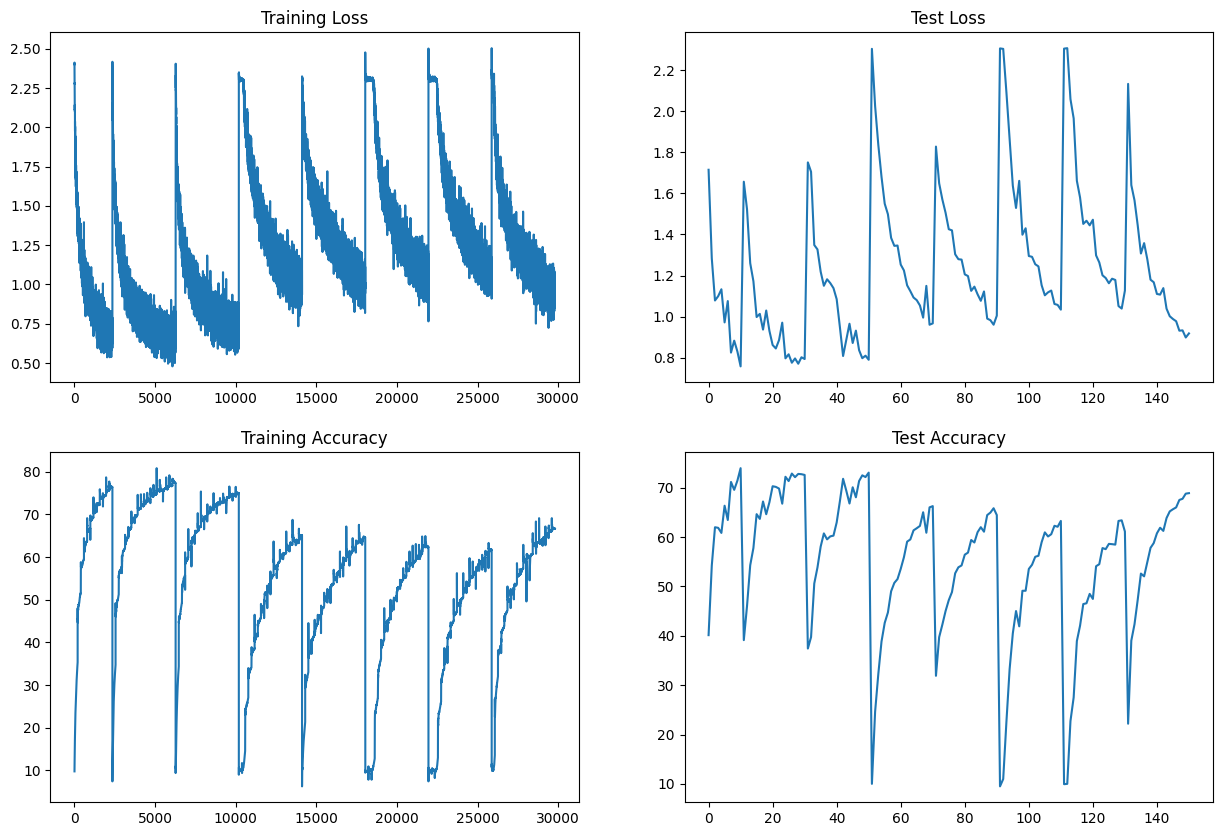

In [78]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")